In [1]:
# importing the libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn.image import resample_img
from nilearn.image import new_img_like, load_img, clean_img, crop_img
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
import glob

# for creating validation set
from sklearn.model_selection import train_test_split
# for evaluating the model
from sklearn.metrics import accuracy_score


# PyTorch libraries and modules
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
import h5py
from torchsummary import summary

from IPython import display
%matplotlib inline


In [2]:
def show_slice(data,idx = 0):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    im=axs[0].imshow(data[idx,:,:])
    fig.colorbar(im,ax=axs[0])
    im=axs[1].imshow(data[:,idx,:])
    fig.colorbar(im,ax=axs[1])
    im=axs[2].imshow(data[:,:,idx])
    fig.colorbar(im,ax=axs[2])
    ds = data.shape
    plt.suptitle('Slice {}, dim={}x{}x{}'.format(idx,ds[0],ds[1],ds[2]))
    plt.show()

In [3]:
def process_scans(d='../data/brainmask_nii/',resample = 3, crop=True):
    df=pd.read_csv('../data/brainmask_nii/age_ixi_and_oasis.csv')
    files = df['id']
    X=[];
    y=df['binary'].to_numpy();
    yage=df['age'].to_numpy();
    for f in tqdm(files):
        tmp=nib.load(d+f+'-brainmask.nii')
        dtmp = resample_img(tmp, target_affine=np.eye(3)*resample*1.0, interpolation='nearest')
        if crop:
            # we know that in our sample 53 70 58 are the largest
            # brains, so we crop first and then embed
            tc = crop_img(dtmp).get_fdata()
            te = np.zeros((53,70,58))
            d1 = np.floor((53-tc.shape[0])/2).astype(np.int16)
            d2 = np.floor((70-tc.shape[1])/2).astype(np.int16)
            d3 = np.floor((58-tc.shape[2])/2).astype(np.int16)
            te[d1:d1+tc.shape[0],
              d2:d2+tc.shape[1],
              d3:d3+tc.shape[2]]=tc
            X.append(te)
        else:
            X.append(dtmp.get_fdata()[:86,:86,:86])
    return X,y,yage
# X,y,yage = process_scans()
# X = np.array(X)
# np.save('X_crop.npy',X)
# np.save('y.npy',y)
# np.save('yage.npy',yage)

In [4]:
X = np.load('X_crop.npy',allow_pickle=True)
#X = np.load('X.npy')
#y = np.load('y.npy')
y = np.load('yage.npy')

In [5]:
for i in range(len(X)):
    tmp = X[i].reshape(-1)
    mitmp = np.min(tmp)
    matmp = np.max(tmp)
    X[i]= (X[i]-mitmp)/(matmp-mitmp)

In [6]:
[Xtrain,Xtest,ytrain,ytest]=train_test_split(X,y,test_size=0.2, 
                                             random_state=21)#, 
                                             #stratify=y)
del(X)
del(y)

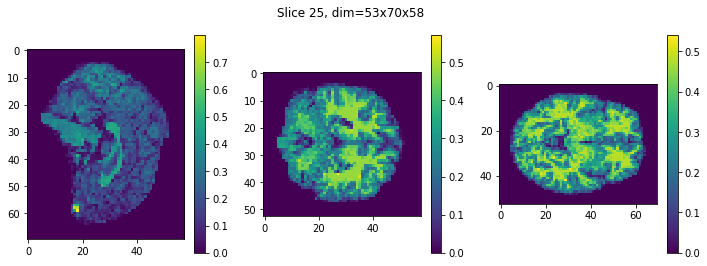

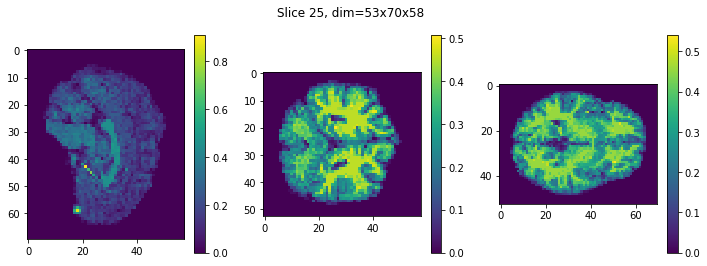

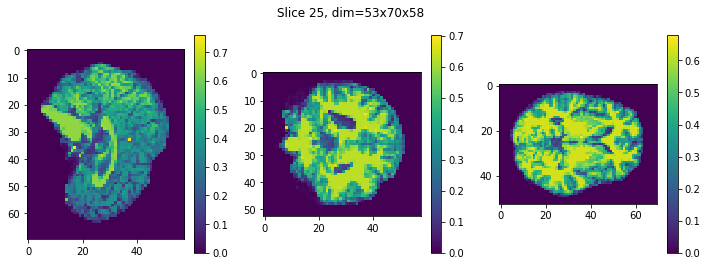

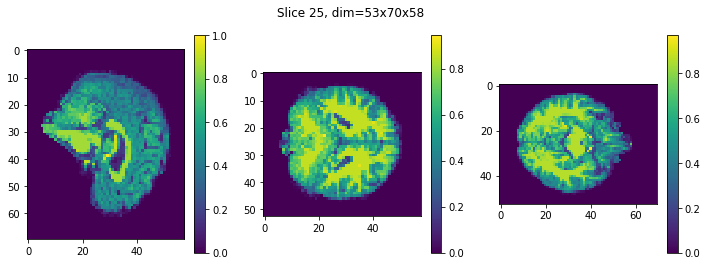

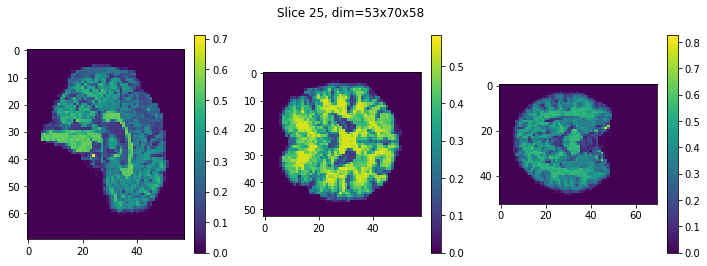

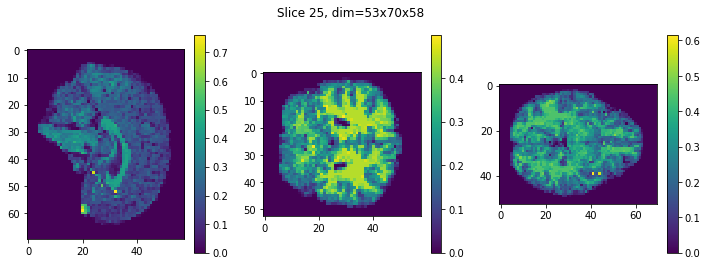

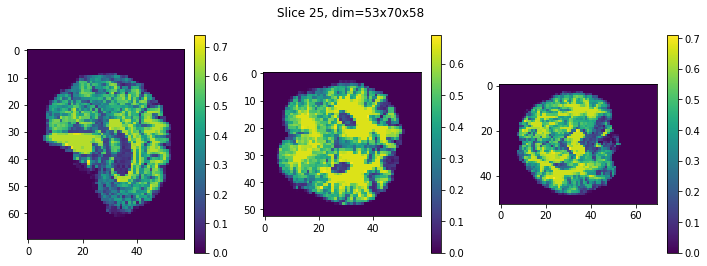

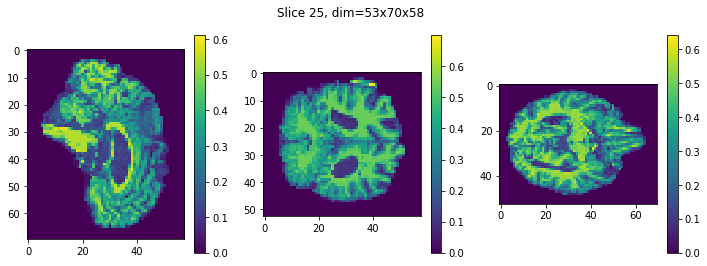

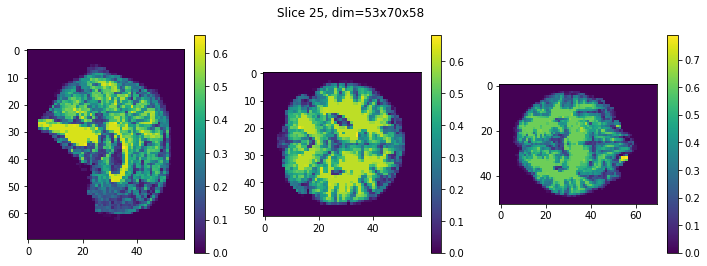

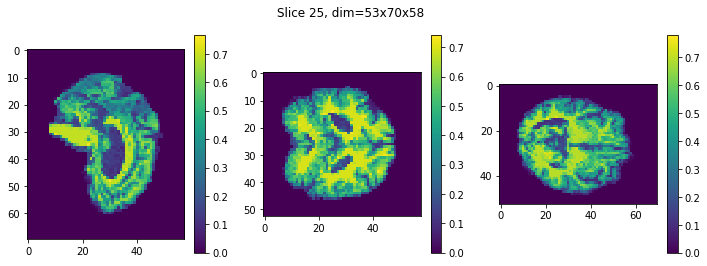

In [7]:
for i in range(5):
    show_slice(Xtrain[10+i],25)
for i in range(5):    
    show_slice(Xtest[10+i],25)

In [8]:
train_x = torch.from_numpy(Xtrain).float().view(Xtrain.shape[0],1,53,70,58)
#train_y = torch.from_numpy(ytrain).long()
train_y = torch.from_numpy(ytrain).float()
test_x = torch.from_numpy(Xtest).float().view(Xtest.shape[0],1,53,70,58)
#test_y = torch.from_numpy(ytest).long()
test_y = torch.from_numpy(ytest).float()

batch_size = 32 #We pick beforehand a batch_size that we will use for the training


# Pytorch train and test sets
train = torch.utils.data.TensorDataset(train_x,train_y)
test = torch.utils.data.TensorDataset(test_x,test_y)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size= batch_size, shuffle = False)
del(Xtrain)
del(Xtest)

In [9]:
num_classes = 1

# Create CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv_layer1 = self._conv_layer_set(1, 8)
        self.conv_layer2 = self._conv_layer_set(8, 16)
        self.conv_layer3 = self._conv_layer_set(16, 32)
        self.conv_layer4 = self._conv_layer_set(32, 64)
        self.fc1 = nn.Linear(2304, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.batch=nn.BatchNorm1d(128)
        self.drop=nn.Dropout(p=0.15)        
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv3d(in_c, out_c, kernel_size=(3,3,3), padding=1),
        nn.BatchNorm3d(out_c),
        nn.ReLU(),
        nn.MaxPool3d((2, 2, 2)),
        )
        return conv_layer
    
    def _conv_layer_set2(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv3d(in_c, out_c, kernel_size=(2,2,2), padding=1),
        nn.Conv3d(out_c, out_c, kernel_size=(2,2,2), padding=1),
        nn.ReLU(),
        nn.MaxPool3d((2, 2, 2)),
        )
        return conv_layer

    def forward(self, x):
        # Set 1
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.drop(out)
        out = self.relu(out)
        out = self.fc3(out)
        
        return out

In [16]:
#Definition of hyperparameters
n_iters = 1000
num_epochs = n_iters / (len(train_x) / batch_size)
num_epochs = int(num_epochs)
device = torch.device("cuda:0") # use cuda device 0

print('running',num_epochs,'on',device)

# Create CNN
model = CNNModel()
model.to(device)
print(summary(model,input_size=(1,53,70,58)))

# # Cross Entropy Loss 
# error = nn.CrossEntropyLoss()

# MSR Loss
error = nn.MSELoss()

# SGD Optimizer
learning_rate = 0.00005
optimizer = torch.optim.SGD(model.parameters(),
                             lr=learning_rate,
                             weight_decay=0.0005,
                             momentum=0.9)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2, last_epoch=-1) 

running 33 on cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 8, 53, 70, 58]             224
       BatchNorm3d-2        [-1, 8, 53, 70, 58]              16
              ReLU-3        [-1, 8, 53, 70, 58]               0
         MaxPool3d-4        [-1, 8, 26, 35, 29]               0
            Conv3d-5       [-1, 16, 26, 35, 29]           3,472
       BatchNorm3d-6       [-1, 16, 26, 35, 29]              32
              ReLU-7       [-1, 16, 26, 35, 29]               0
         MaxPool3d-8       [-1, 16, 13, 17, 14]               0
            Conv3d-9       [-1, 32, 13, 17, 14]          13,856
      BatchNorm3d-10       [-1, 32, 13, 17, 14]              64
             ReLU-11       [-1, 32, 13, 17, 14]               0
        MaxPool3d-12          [-1, 32, 6, 8, 7]               0
           Conv3d-13          [-1, 64, 6, 8, 7]          55,360
      BatchNorm3d-

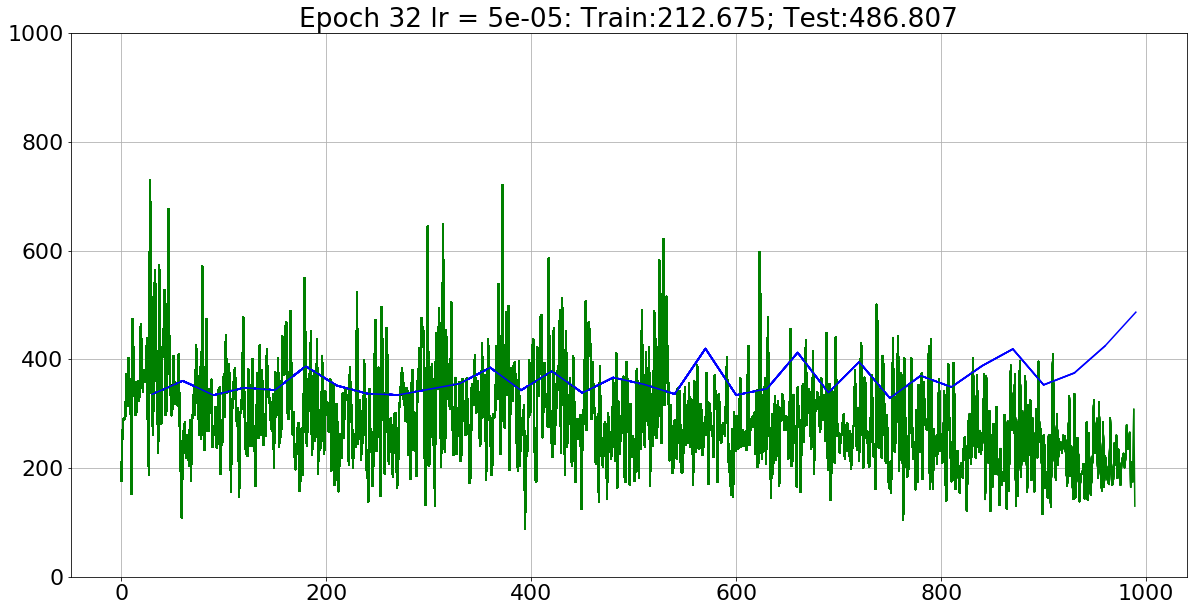

In [27]:
torch.cuda.empty_cache()
# CNN model training
count = 0
loss_list = []
count_list=[]
batch_accuracy_list = []
accuracy_list = []
plt.figure(figsize=(20,10))
axes = plt.gca()
axes.set_ylim([0,1000])
plt.grid(True)
plt.rcParams.update({'font.size': 22})
for epoch in range(num_epochs):
    batch_accuracy = 0
    batch_total = 0
    #scheduler.step()
    for i, (train, labels) in enumerate(train_loader):  
        #train = Variable(images.view(batch_size,1,86,86,86))
        labels = Variable(labels)
        # Clear gradients
        optimizer.zero_grad()
        # Forward propagation
        outputs = model(train.to(device)).squeeze()
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels.to(device))
        loss_list.append(loss.data)
        # Calculating gradients
        loss.backward()
        # Update parameters
        optimizer.step()
        count+=1
        plt.plot(loss_list,'g-')
        display.display(plt.gcf())
        display.clear_output(wait=True) 

        # Total number of labels
        batch_total += 1
        batch_accuracy += loss.data
        
    batch_accuracy_list.append(batch_accuracy/batch_total)
        
#         # Get predictions from the maximum value
#         predicted = torch.max(outputs.data, 1)[1]

#         # Total number of labels
#         batch_total += len(labels)
#         batch_accuracy += (predicted == labels.to(device)).sum().data
    
#     batch_accuracy_list.append(100*batch_accuracy/batch_total)

    with torch.no_grad():

#     correct = 0
#     total = 0
#     # Iterate through test dataset
#     for test, labels in test_loader:

#         #test = Variable(images)
#         # Forward propagation
#         outputs = model(test.to(device))

#         # Get predictions from the maximum value
#         predicted = torch.max(outputs.data, 1)[1]

#         # Total number of labels
#         total += len(labels)
#         correct += (predicted == labels.to(device)).sum().data

#     accuracy = 100 * correct / float(total)
#     plt.title('Epoch {:}: Train:{:.3f}; Test:{:.3f}'.format(
#               epoch,100*batch_accuracy/batch_total,accuracy))
#     accuracy_list.append(accuracy)
        accuracy = 0
        total = 0
        for test, labels in test_loader:
            # Forward propagation
            outputs = model(test.to(device)).squeeze()
            accuracy += error(outputs,labels.to(device))
            total +=1
        count_list.append(count)
        accuracy_list.append(accuracy)
    plt.plot(np.array(count_list),np.array(accuracy_list)/total,'b')
    plt.title('Epoch {:} lr = {:}: Train:{:.3f}; Test:{:.3f}'.format(
        epoch,
        learning_rate,#scheduler.get_lr()[0],
        batch_accuracy/batch_total,
        accuracy/total))
    display.display(plt.gcf())
    display.clear_output(wait=True) 



In [28]:
with torch.no_grad():
    accuracy = 0
    total = 0
    allxt = []
    allyt = []
    allx = []
    ally = []
    for test, labels in train_loader:
        # Forward propagation
        outputs = model(test.to(device)).squeeze()
        allxt.append(outputs.cpu().numpy())
        allyt.append(labels.cpu().numpy())
        accuracy += error(outputs,labels.to(device))
        total +=1
    for test, labels in test_loader:
        # Forward propagation
        outputs = model(test.to(device)).squeeze()
        allx.append(outputs.cpu().numpy())
        ally.append(labels.cpu().numpy())
        accuracy += error(outputs,labels.to(device))
        total +=1

In [29]:
allxf = [y for x in allx for y in x]
allyf = [y for x in ally for y in x]
allxft = [y for x in allxt for y in x]
allyft = [y for x in allyt for y in x]

In [30]:
from sklearn.linear_model import LinearRegression

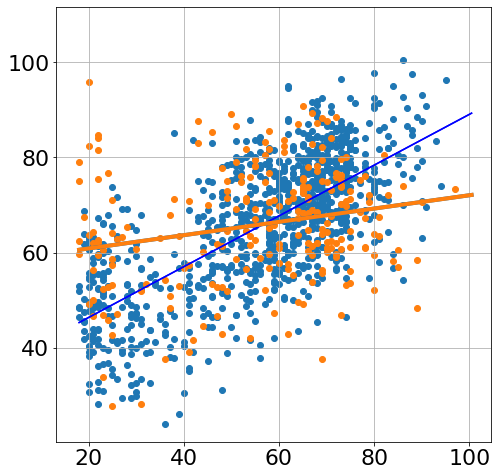

In [31]:
plt.figure(figsize=(8,8))
plt.scatter(allyft,allxft)
mi =np.min([np.min(allyft),np.min(allxft)])
ma =np.max([np.max(allyft),np.max(allxft)])
reg = LinearRegression().fit(np.array(allyft).reshape(-1, 1),
                             np.array(allxft))
p1 = np.array([[mi, mi]]).reshape(-1, 1)
p2 = np.array([[ma,ma]]).reshape(-1, 1)
plt.plot(np.array([mi,ma]).reshape(-1, 1),
         np.array([reg.predict(p1),reg.predict(p2)]),'b')
plt.scatter(allyf,allxf)
reg = LinearRegression().fit(np.array(allyf).reshape(-1, 1),
                             np.array(allxf))
plt.plot(np.array([mi,ma]).reshape(-1, 1),
         np.array([reg.predict(p1),reg.predict(p2)]),linewidth=4)
plt.axis('square')
plt.grid(True)

In [ ]:
reg.predict(p1)